# Is seasonality a good predictor of implied volatility?

The goal of this project is to test whether or not seasonality is a good predictor of implied volatility in CBOT grain products. The full project attempted four methods to predict model implied volatility, settling on a cubic spline interpolation. This is the implementation of that model.

In [1]:
#import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import scipy as sp

from scipy.interpolate import UnivariateSpline

### In the section below, we aggregate implied volatility data into a data frame.

In order to test our initial hypothesis, we need to pull some implied vol data and aggregate it into a single dataframe. We are using CSV files exported from a subscription website. Next, we need to set a range of days-to-expiration that we want to study, and drop any data not related to implied vol or that DTE range.

#### Create function to pull volatility data 

In [2]:
# created custom function to wrap up data cleaning work on vol csv files
# its primary purpose is to take a CSV file and extract only the front month vols

def front_vol_pull(csv, min_dte, max_dte, obs_id='Observation Date',
                   vol_id='result', title_id='Stat', exp_id='exp_date0', 
                   location='C:/Users/Trader/Desktop/Dropbox/Data Science/DataSets/ImpVol/'):
    """
    csv input must be a .CSV file with file extension. location must be a full file location folder. 
    min_dte & max_dte must be integers. obs_id describes heading above colume with dates, 
    title_id describes heading above column with data descriptions,
    vol_id describes desired data from title_id column in csv, exp_id describes expiration date title in Stat column
    """
    
    # read in csv file from location as csv input
    df = pd.read_csv(location+csv, index_col=False)
    
    # converts 'Observation Date' column in csv from string to pandas datetime object
    df[obs_id] = pd.to_datetime(df[obs_id])
    
    # creates two dataframes, one with vol data and one with expiry dates
    dfvols = df.loc[df[title_id] == vol_id]
    dfexp = df.loc[df[title_id] == exp_id]
    
    # rename data column in vol dataframe to 'Vol'. 'Value' is heading of column with numerical data
    dfvols.rename(columns={'Value':'Vol'}, inplace=True)
    dfvols['Vol'] =  dfvols['Vol'].astype(float)
    
    # create truncated version of dfexp containing just the observation date and the expiry
    # promote the 'Observation Date' & 'Year' column to the multi-index of the dataframe
    # need to use multi-index to join with other dataframes
    dfexp_trunc = dfexp[[obs_id, 'Year', 'Value']]
    dfexp_trunc = dfexp_trunc.set_index([obs_id, 'Year'])
    
    # join the two dataframes on the multi-index of 'Observation Date' & 'Year'
    dfvols_exp = dfvols.join(dfexp_trunc, on=[obs_id, 'Year'])
    
    # remove 'Stat' column and rename 'Value' to 'Expiry'
    del dfvols_exp[title_id]
    dfvols_exp.rename(columns={'Value':'Expiry'}, inplace=True)
    
    # converts 'Expiry' data to a pandas datetime object
    dfvols_exp['Expiry'] = pd.to_datetime(dfvols_exp['Expiry'])
    
    # creates new column with Days to Expiration as a timedelta
    dfvols_exp['DTE'] = dfvols_exp['Expiry'] - dfvols_exp[obs_id]
    
    # converts dte inputs to timedelta objects and creates new dataframe with filtered dates
    max_dte = pd.Timedelta(days=max_dte)
    min_dte = pd.Timedelta(days=min_dte)
    df_fronts = dfvols_exp[(dfvols_exp['DTE'] <= max_dte) & (dfvols_exp['DTE'] > min_dte)]
    
    return df_fronts

#### Pull and clean volatility data

From here, we want to use the custom `front_vol_pull` function on a list of csv files containing implied volatility data. Then sort the data by time to expiration and drop any duplicate dates

In [3]:
# create function to map day number to calendar date in pd.datetime format

def day_num(date):
    year = date.year
    start = pd.datetime(year-1,12,31)
    day = date - start
    return(day.days)

In [4]:
def sorted_vol_data(list_of_csvs, save_location=None):
    '''
    Returns a pandas dataframe containing the data returned from the function front_vol_pull for each
    csv file in the list_of_csvs. Data contains only front month vols and is sorted by observation date.
    save_location must be a string with a full file location if you want to export the dataframe to a csv,
    leave as None if not.
    '''
    # create one large df with all data; create list of dataframes and concatenate them at the end of the process

    full_data_set = pd.DataFrame()

    for i in list_of_csvs:
        df = front_vol_pull(i,10,80)
        full_data_set = full_data_set.append(df)

    # sort full_data_set based on DTE, drop entries with observation date overlap, keep shortest DTE
    # re-sort by 'Observation Date' for better clarity, redefine as final_data
    # can add parameter 'ascending=False' after 'DTE' to keep longer dated vols and avoid some front month noise

    full_data_set = full_data_set.sort_values('DTE').drop_duplicates('Observation Date', keep='first')
    full_data_set = full_data_set.sort_values('Observation Date')
    
    if save_location is not None:
        full_data_set.to_csv(path_or_buf=save_location)

    return full_data_set

In [5]:
# create list of vol files

vol_files = ['SFvol.csv','SHvol.csv','SKvol.csv','SNvol.csv','SQvol.csv','SUvol.csv','SXvol.csv']

In [6]:
final_data = sorted_vol_data(vol_files)

C:\Users\Trader\Anaconda3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
# limit data to contract years 2014 or later

recent_data2 = final_data[final_data['Year'] > 2013]

In [8]:
def avg_vol_by_day(vol_data, years):
    '''
    
    '''

    # map day_num function to 'Observation Date'

    vol_data['Day Num'] = vol_data.apply(lambda x: day_num(x['Observation Date']), axis=1)

    # create a list of dataframes, each containing day number and vol for that day

    data_by_year = []
    for year in years:
        data = vol_data[(vol_data['Observation Date'] <= pd.datetime(year,12,31))
                             & (vol_data['Observation Date'] >= pd.datetime(year,1,1))]
        data = data[['Day Num','Vol']]
        data.set_index('Day Num', inplace=True)
        data_by_year.append(data)

    # creates a new dataframe with a range of day numbers, then joins vol data to that dataframe for each year in a range

    years_strings = [str(i) for i in years]

    vol_by_day = pd.DataFrame({'Day Num': range(1,367)})

    position = 0

    for year in years_strings:

        vol_by_day = vol_by_day.join(data_by_year[position], on='Day Num', rsuffix='_'+year)
        vol_by_day.rename(columns={'Vol': year}, inplace=True)

        position += 1
        
    # impute implied volatility for days with 'NaN' in vol_data dataframe
    # because NaN values are weekend days or holidays, 
    # we can assume the implied volatility for that day is equal to the nearst day. 
    # i.e. The implied vol on Saturday when markets are closed is assumed to be the implied vol at close on Friday
    # limit=1 means only 1 NaN value will be filled. Alternate bfill & ffill to get best approximation

    vol_by_day = vol_by_day.fillna(method='ffill', limit=1)
    vol_by_day = vol_by_day.fillna(method='bfill', limit=1)
    vol_by_day = vol_by_day.fillna(method='ffill')
    vol_by_day = vol_by_day.fillna(method='bfill')
    
    # create column with average of year columns

    vol_by_day['Day Avg Vol'] = vol_by_day[years_strings].mean(axis=1)
    
    return vol_by_day

In [9]:
vol_data = avg_vol_by_day(recent_data2, range(2014,2019))

C:\Users\Trader\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Were going to implement a regression spline using knots along the path of average vol through the year. 

Wrap into single function all below

In [10]:
# create X and y data

Xdata = vol_data['Day Num']
ydata = vol_data['Day Avg Vol']

In [11]:
# k is the number of terms in the polynomials that comprise the spline, 3 = cubic
# s is a smoothing factor

spl = UnivariateSpline(Xdata, ydata, k=3, s=700)

# creates function for first derivative of spl spline implemented above, used in graph

derivative = spl.derivative()

print('Avg. Vol Error: ', round(np.sqrt(spl.get_residual() / 366), 3))

Avg. Vol Error:  1.383


C:\Users\Trader\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'1st Derivative')

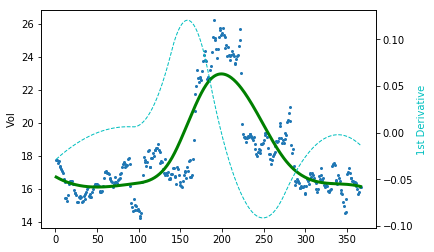

In [12]:
# creates a plot with two axis, 111 indicates relative position and size of each plot
# 211 can be used to create stacked plots

fig = plt.figure()
plt.plot(Xdata, ydata, 'o', ms=2)
ax1 = fig.add_subplot(1,1,1)
ax1.plot(Xdata, spl(Xdata), 'g', lw=3)
ax1.set_ylabel('Vol')

ax2 = ax1.twinx()
ax2.plot(Xdata, derivative(Xdata), 'c--', lw=1)
ax2.set_ylabel('1st Derivative', color='c')